# Data Mining - Project

## Objective:
We will create a model to detect Fake news using Python.
Fake news refers to information content that is false, misleading or whose source cannot be verified.

## Make necessary imports:

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\parij\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\parij\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**fakenews.csv**: A full training dataset with the following attributes:

<ul>
    <li><b>id</b>: unique id for a news article</li>
    <li><b>title</b>: the title of a news article</li>
    <li><b>author</b>: author of the news article</li>
    <li><b>text</b>: the text of the article; could be incomplete</li>
    <li><b>label</b>: a label that marks the article as potentially unreliable</li>
    <li>1: real news</li>
    <li>0: fake news</li>
</ul>

In [3]:
data = pd.read_csv('fakenews.csv')
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


## Data Cleaning and Preprocessing

Check the size of the dataframe/table as it would decide whether we can drop the rows with null values without
affecting the size of our dataset or not

In [4]:
data.shape

(20800, 5)

In [5]:
#Checking the total number of missing values in each of the columns.
data.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

Since there are 1957 rows with missing values, hence we may need to delete these many rows, but it won't be ideal as we may lose almost 10% data. Hence we will fill cells with missing values with empty string

In [6]:
df = data.fillna('')
df.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [7]:
df['label'].value_counts()

label
1    10413
0    10387
Name: count, dtype: int64

Now Let’s explore the unique values in the each category using below code.

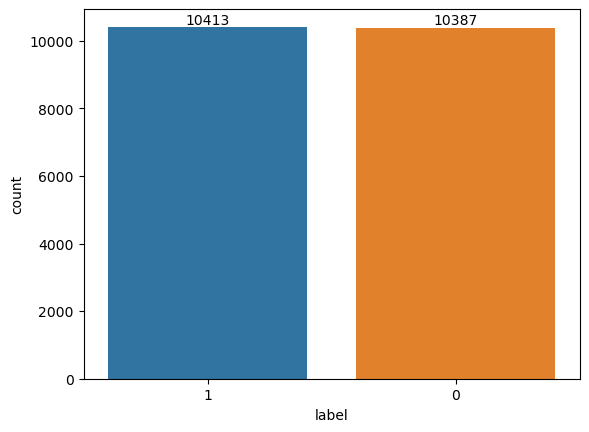

In [8]:
ax = sns.countplot(data=df,
              x='label',
              order=df['label'].value_counts().index)
for label in ax.containers:
    ax.bar_label(label)
plt.show()

Now we can check if we can remove any columns that are not required, i.e., columns that does not determine if the news is fake or not

We’ll try to reduce those 5 columns to only 2 columns since it will be easier for us to train the model. For that we’ll combine the **title** and the **author** columns into one, naming it as **content**. We can drop the other columns as they don’t have much effect on determining whether the article is fake or not. This step will leave us with 2 columns - content and label.

We can drop columns **title** and **author**

In [9]:
df['content'] = df['author'] + ' ' + df['title']
df = df.drop(['author', 'title'], axis = 1)

**Stemming**

Now coming to the stemming part.

Stemming is a natural language processing technique that is used to reduce words to their base form, also known as the root form. The process of stemming is used to normalize text and make it easier to process. It is an important step in text pre-processing, and it is commonly used in information retrieval and text mining applications.

A stemming algorithm reduces the words “chocolates”, “chocolatey”, “choco” to the root word, “chocolate” and “retrieval”, “retrieved”, “retrieves” reduce to the stem “retrieve”.

There are several different algorithms for stemming. The Porter stemmer is the most widely used algorithm.

In [10]:
stemmer = PorterStemmer()

In [11]:
#Example
sentence = "Programmers program with programming languages"
stemmer.stem(sentence)

'programmers program with programming languag'

We create a new Porter stemmer for us so that we can use the function without explicitly typing PorterStemmer() every time.

In [12]:
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ', content) #1
    stemmed_content = stemmed_content.lower() #2
    stemmed_content = stemmed_content.split() #3
    stemmed_content = [stemmer.stem(word) for word in stemmed_content if not word in stopwords.words('english')] #4
    stemmed_content = ' '.join(stemmed_content) #5
    return stemmed_content #6

**#1** First we use the **re** package and remove everything that is not a letter (lower or uppercase letters).

**#2** We then convert every uppercase letter to a lower one.

**#3** We then split the each sentence into a list of words.

**#4** Then we use the stemmer and stem each word which exists in the column and remove every english stopword present in the list.

**#5** We then join all these words which were present in the form of a list and convert them back into a sentence.

**#6** Finally we return the stemmed_content which has been preprocessed.

In [13]:
#Applying this function to our dataset,

df['content'] = df['content'].apply(stemming)
df['content'].head()

0    darrel lucu hous dem aid even see comey letter...
1    daniel j flynn flynn hillari clinton big woman...
2               consortiumnew com truth might get fire
3    jessica purkiss civilian kill singl us airstri...
4    howard portnoy iranian woman jail fiction unpu...
Name: content, dtype: object

In [14]:
df.head()

,id,text,label,content
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,1,darrel lucu hous dem aid even see comey letter...
1,1,Ever get the feeling your life circles the rou...,0,daniel j flynn flynn hillari clinton big woman...
2,2,"Why the Truth Might Get You Fired October 29, ...",1,consortiumnew com truth might get fire
3,3,Videos 15 Civilians Killed In Single US Airstr...,1,jessica purkiss civilian kill singl us airstri...
4,4,Print \nAn Iranian woman has been sentenced to...,1,howard portnoy iranian woman jail fiction unpu...


Let’s visualize the WordCloud for fake and real news separately.

In [15]:
real_news = ' '.join(word for word in df['content'][df['label']==1].astype(str))
real_word_cloud = WordCloud(width = 1500, height = 750, random_state = 21, max_font_size = 110, collocations = False)

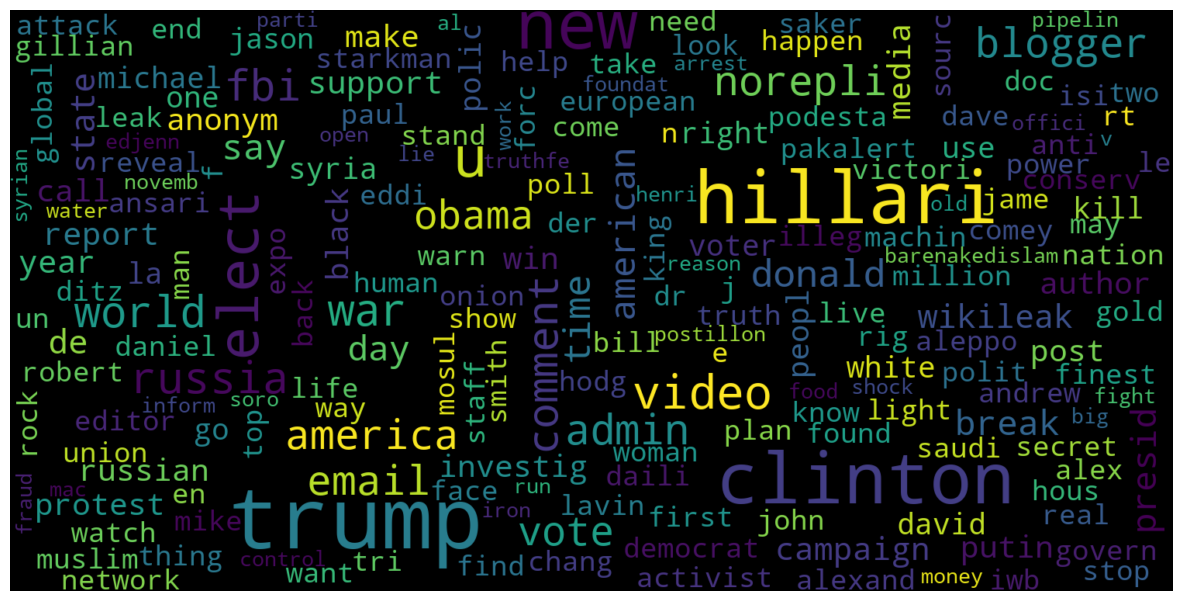

In [16]:
plt.figure(figsize = (15,10))
plt.imshow(real_word_cloud.generate(real_news), interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [17]:
fake_news = ' '.join(word for word in df['content'][df['label']==0].astype(str))
fake_word_cloud = WordCloud(width = 1500, height = 750, random_state = 21, max_font_size = 110, collocations = False)

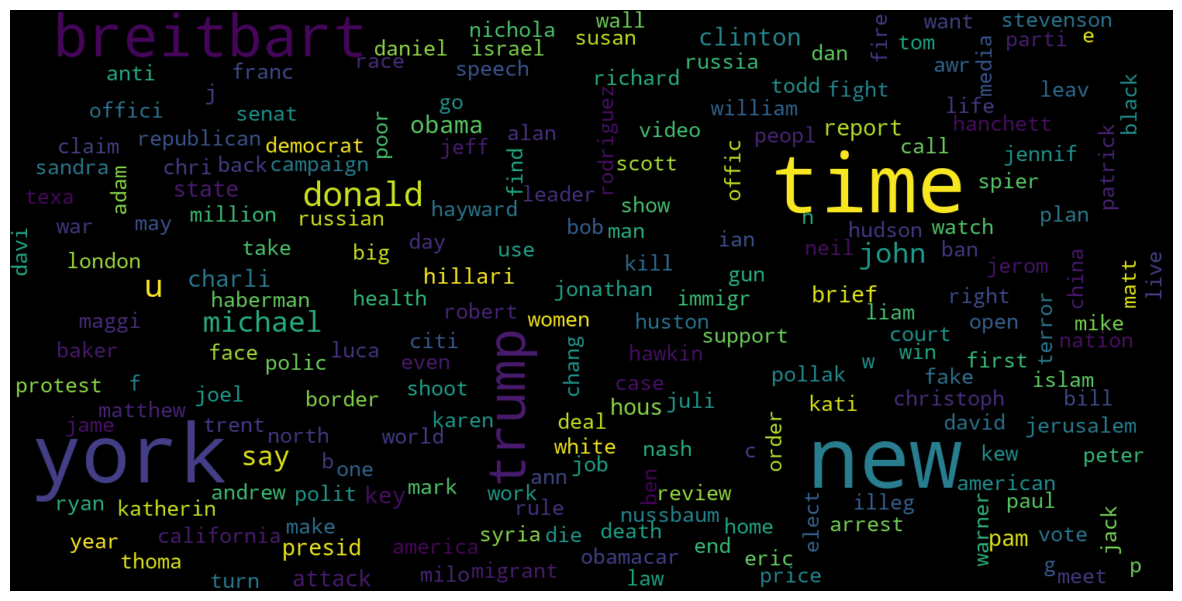

In [18]:
plt.figure(figsize = (15,10))
plt.imshow(fake_word_cloud.generate(fake_news), interpolation = 'bilinear')
plt.axis('off')
plt.show()

Let’s plot the bargraph of the top 20 most frequent words.

<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

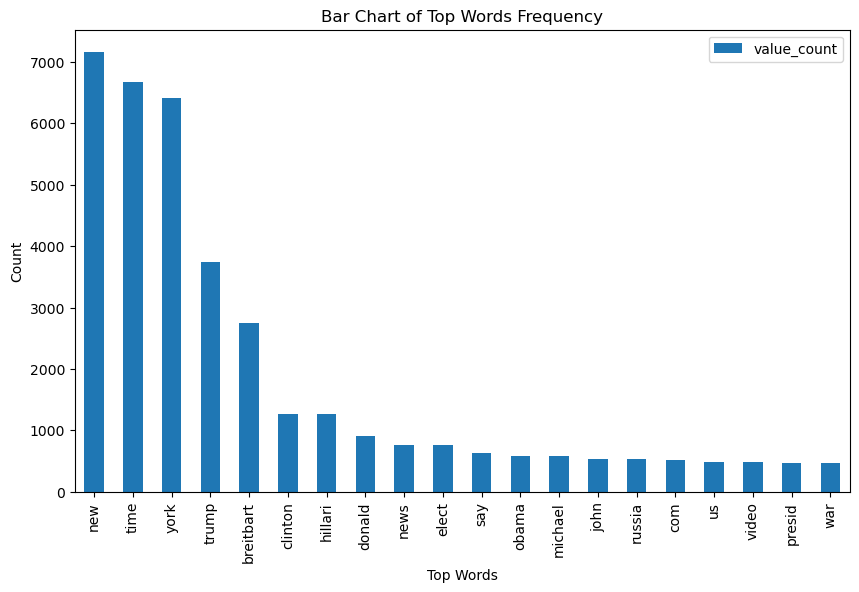

In [19]:
word_freq = {}
for i in range(len(df)):
    all_words = df['content'][i].split()
    for word in all_words:
        if word not in word_freq:
            word_freq[word] = 1
        else:
            word_freq[word] = word_freq[word] + 1

word_freq = sorted(word_freq.items(), key = lambda x:x[1], reverse=True)

i = 0
for word in word_freq:
    if len(word[0]) <= 1:
        word_freq.remove(word)
    i = i + 1

df1 = pd.DataFrame(word_freq, columns = ['value', 'value_count'])

df1[:20].set_index(df1['value'][:20]).plot(kind = 'bar',
         figsize=(10, 6),
         xlabel="Top Words",
         ylabel="Count",
         title="Bar Chart of Top Words Frequency"
        )

### Converting text into Vectors

In [20]:
#Next step is to name our input and output features

X = df.content.values
y = df.label.values

Our last preprocessing step would be to transform our textual X to numerical so that our ML model can understand it and can work with it. This is where **TfidfVectorizer** comes into play.

In [21]:
X = TfidfVectorizer().fit_transform(X)
print(X)

  (0, 15686)	0.28485063562728646
  (0, 2483)	0.3676519686797209
  (0, 7692)	0.24785219520671603
  (0, 8630)	0.29212514087043684
  (0, 2959)	0.2468450128533713
  (0, 13473)	0.2565896679337957
  (0, 4973)	0.233316966909351
  (0, 267)	0.27010124977708766
  (0, 3792)	0.2705332480845492
  (0, 7005)	0.21874169089359144
  (0, 8909)	0.3635963806326075
  (0, 3600)	0.3598939188262559
  (1, 1894)	0.15521974226349364
  (1, 2223)	0.3827320386859759
  (1, 16799)	0.30071745655510157
  (1, 1497)	0.2939891562094648
  (1, 2813)	0.19094574062359204
  (1, 6816)	0.1904660198296849
  (1, 5503)	0.7143299355715573
  (1, 3568)	0.26373768806048464
  (2, 5389)	0.3866530551182615
  (2, 5968)	0.3474613386728292
  (2, 9620)	0.49351492943649944
  (2, 15611)	0.41544962664721613
  (2, 2943)	0.3179886800654691
  :	:
  (20797, 1287)	0.3353805680413986
  (20797, 13122)	0.24825263521976057
  (20797, 12344)	0.27263457663336677
  (20797, 14967)	0.3115945315488075
  (20797, 12138)	0.24778257724396505
  (20797, 9518)	0.295420

**Splitting the Dataset**

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 2)

This means that we have divided our dataset into **80%** as training set and **20%** as test set. **stratify = y** implies that we have made sure that the division into train-test sets have around equal distribution of either classes (0 and 1 or Real and Fake). **random_state = 2** will guarantee that the split will always be the same.

### Training the Model

Fitting the model to our dataset using **Logistics Regression**

In [23]:
model1 = LogisticRegression()
model1.fit(X_train, y_train)

LogisticRegression()

Now that we have trained it, let’s check the **accuracy** and **precision** of our training set predictions

In [63]:
for i in np.arange(0.1, 1.0, 0.1):
    print('prediction with threshold {}:'.format(i))
    #Training set Accuracy
    print('Accuracy score:', accuracy_score(y_train, model1.predict_proba(X_train)[:, 1] >= i))
    #Testing set Accuracy
    print('Accuracy score:', accuracy_score(y_test, model1.predict_proba(X_test)[:, 1] >= i))

prediction with threshold 0.1:
Accuracy score: 0.8712740384615385
Accuracy score: 0.8694711538461538
prediction with threshold 0.2:
Accuracy score: 0.9325721153846154
Accuracy score: 0.9276442307692307
prediction with threshold 0.30000000000000004:
Accuracy score: 0.9569110576923077
Accuracy score: 0.9475961538461538
prediction with threshold 0.4:
Accuracy score: 0.97578125
Accuracy score: 0.965625
prediction with threshold 0.5:
Accuracy score: 0.9865985576923076
Accuracy score: 0.9790865384615385
prediction with threshold 0.6:
Accuracy score: 0.990625
Accuracy score: 0.9855769230769231
prediction with threshold 0.7000000000000001:
Accuracy score: 0.9883413461538462
Accuracy score: 0.9814903846153846
prediction with threshold 0.8:
Accuracy score: 0.9703725961538462
Accuracy score: 0.9584134615384615
prediction with threshold 0.9:
Accuracy score: 0.8134014423076923
Accuracy score: 0.7915865384615385


For threshold value of **0.6**, I got about **99%** accuracy for training dataset and **98.5%** accuracy for testing dataset, which is pretty good.

So test accuracy is also pretty good.

In [59]:
#Training set Precision
print('Precision Score:', precision_score(y_train, model1.predict_proba(X_train)[:, 1] >= 0.6))
#Testing set Precision
print('Precision Score:', precision_score(y_test, model1.predict_proba(X_test)[:, 1] >= 0.6))

Precision Score: 0.9916987487969201
Precision Score: 0.9832775919732442


So I got about **99%** precision for training dataset and **98%** precision for testing dataset, which is pretty good.

So test Precision is also pretty good.

Now, Fitting the model to our dataset using **Decision Tree Classifier**

In [60]:
from sklearn.tree import DecisionTreeClassifier

In [61]:
model2 = DecisionTreeClassifier()
model2.fit(X_train, y_train)

DecisionTreeClassifier()

In [70]:
#Training set Accuracy
print('Accuracy score:', accuracy_score(y_train, model2.predict(X_train)))
#Testing set Accuracy
print('Accuracy score:', accuracy_score(y_test, model2.predict(X_test)))

Accuracy score: 1.0
Accuracy score: 0.9932692307692308


So I got about **100%** accuracy for training dataset and **99%** accuracy for testing dataset, which is pretty good.

In [71]:
#Training set Precision
print('Precision Score:', precision_score(y_train, model2.predict(X_train)))
#Testing set Precision
print('Precision Score:', precision_score(y_test, model2.predict(X_test)))

Precision Score: 1.0
Precision Score: 0.9932789246279404


So I got about **100%** precision for training dataset and **99%** precision for testing dataset, which is pretty good.

So test Precision is also pretty good.

**Building a system**

Finally to make this model useful we need to make a system. Taking a sample out of the test-set (I took the first sample)

In [72]:
X_sample = X_test[2]

In [73]:
y_test[2]

1

In [74]:
#Checking our prediction for this sample using logistics regression,

prediction = model1.predict(X_sample)
if prediction == 0:
    print('The NEWS is Real!')
else:
    print('The NEWS is Fake!')

The NEWS is Fake!


In [75]:
#Checking our prediction for this sample using Decision Tree Classifier,

prediction = model2.predict(X_sample)
if prediction == 0:
    print('The NEWS is Real!')
else:
    print('The NEWS is Fake!')

The NEWS is Fake!


# Conclusion

Decision Tree Classifier and Logistic regression are performing well.

# Author
Pari Vinod Chhoriya

Komal Bahadurge